# Telco Customer Churn - Python Analysis
### Main Objective:
1. Exploratory Data Anlaysis
2. Data Pre-processing
3. Model Building
4. Model Evaluation
---

### Import Libraries

In [1]:
# Base library
import pandas as pd
import numpy as np

# MySQL Connector
import mysql.connector
from mysql.connector import Error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Selection, cross-validation
from sklearn.model_selection import train_test_split, cross_val_score

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Model
import optuna
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

e:\Program\Anaconda\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the data

In [2]:
# DB Config
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'telco_churn'
}

In [3]:
# SQL Query to load the data
sql_query = """
SELECT
    c.customerID,
    c.gender,
    c.SeniorCitizen,
    c.Partner,
    c.Dependents,
    a.tenure,
    a.Contract,
    a.PaperlessBilling,
    a.PaymentMethod,
    a.MonthlyCharges,
    a.TotalCharges,
    s.PhoneService,
    s.MultipleLines,
    s.InternetService,
    s.OnlineSecurity,
    s.OnlineBackup,
    s.DeviceProtection,
    s.TechSupport,
    s.StreamingTV,
    s.StreamingMovies,
    ch.Churn
FROM
    customers c
JOIN
    account_info a ON c.customerID = a.customerID
JOIN
    services s ON c.customerID = s.customerID
JOIN
    churn_data ch ON c.customerID = ch.customerID;
"""

# Connect to the database and load the data
# Create a variable 'df' to hold the data
df = None
conn = None # Initialize connection to None

try:
    # Establish the connection
    conn = mysql.connector.connect(**db_config)
    
    if conn.is_connected():
        print("Successfully connected to the MySQL database.")
        
        # Use pandas to execute the query and load data into a DataFrame
        df = pd.read_sql(sql_query, conn)
        
        print("Data successfully loaded into a pandas DataFrame.")

except Error as e:
    print(f"Error connecting to MySQL or fetching data: {e}")

finally:
    # Make sure to close the connection
    if conn and conn.is_connected():
        conn.close()
        print("MySQL connection is closed.")

Successfully connected to the MySQL database.
Data successfully loaded into a pandas DataFrame.
MySQL connection is closed.


C:\Users\dkpc2\AppData\Local\Temp\ipykernel_5692\3995519853.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


In [4]:
# Check if the dataset is loaded properly
if df is not None:
    print("\n--- Data Verification ---")
    
    # Check the number of rows and columns loaded
    # This should show approximately (7043, 21)
    print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
    
    # Display the first 5 rows to see what the data looks like
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    
    # Display summary info to check for null values and data types
    print("\nDataFrame Info:")
    df.info()


--- Data Verification ---
The DataFrame has 7043 rows and 21 columns.

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No\r
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No\r
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   Contract          7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 no

#### Initial Profiling

In [5]:
missing_val = df.isna().sum()
missing_val

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Churn                0
dtype: int64

There's 11 missing values on TotalCharges column. We will drop the missing values.

In [6]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   Contract          7032 non-null   object 
 7   PaperlessBilling  7032 non-null   object 
 8   PaymentMethod     7032 non-null   object 
 9   MonthlyCharges    7032 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7032 non-null   object 
 12  MultipleLines     7032 non-null   object 
 13  InternetService   7032 non-null   object 
 14  OnlineSecurity    7032 non-null   object 
 15  OnlineBackup      7032 non-null   object 
 16  DeviceProtection  7032 non-null   object 
 17  

In [7]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

No duplicate found on the dataset.

#### Exploratory Data Analysis
We will conduct:
1. Check Customer's churn distribution
2. Check customer's gender distribution
3. Check customer's internet service type distribution
4. Check customer's contract type
5. Check customer's churn rate by Contract type
6. Check customer's average MonthlyCharges for customers who churned vs. those who didn't
7. Check customer's churn rate by Internet Service type

Check customer's gender distribution

In [8]:
cust_churn = df.groupby('Churn')[['Churn']].count()
cust_churn = cust_churn.rename(columns={
    'Churn' : 'Count of Churn'
}).reset_index()
cust_churn

,Churn,Count of Churn
0,No\r,5163
1,Yes,1869


) missing from font(s) DejaVu Sans.pykernel_5692\545732050.py:4: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


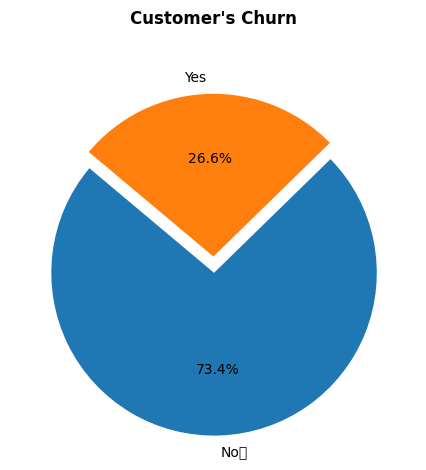

In [9]:
# Customer's gender chart
plt.pie(x='Count of Churn', labels='Churn', data=cust_churn, explode=[0.1, 0], autopct='%1.1f%%', startangle=140)
plt.title("Customer's Churn\n", weight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Gender distribution
cust_gender = df.groupby('gender')[['gender']].count()
cust_gender = cust_gender.rename(columns={
    'gender' : 'Count of gender'
}).reset_index()
cust_gender

,gender,Count of gender
0,Female,3483
1,Male,3549


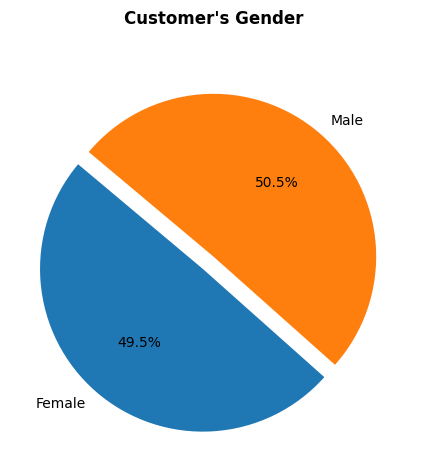

In [11]:
# Customer's gender chart
plt.pie(x='Count of gender', labels='gender', data=cust_gender, explode=[0.1, 0], autopct='%1.1f%%', startangle=140)
plt.title("Customer's Gender\n", weight='bold')
plt.tight_layout()
plt.show()

Check customer's internet service type distribution

In [12]:
# Distribution of internet services
internet_services = df.groupby('InternetService')[['InternetService']].count()
internet_services = internet_services.rename(columns={
    'InternetService' : 'Count of Internet Service'
}).sort_values(by='Count of Internet Service', ascending=False).reset_index()
internet_services

,InternetService,Count of Internet Service
0,Fiber optic,3096
1,DSL,2416
2,No,1520


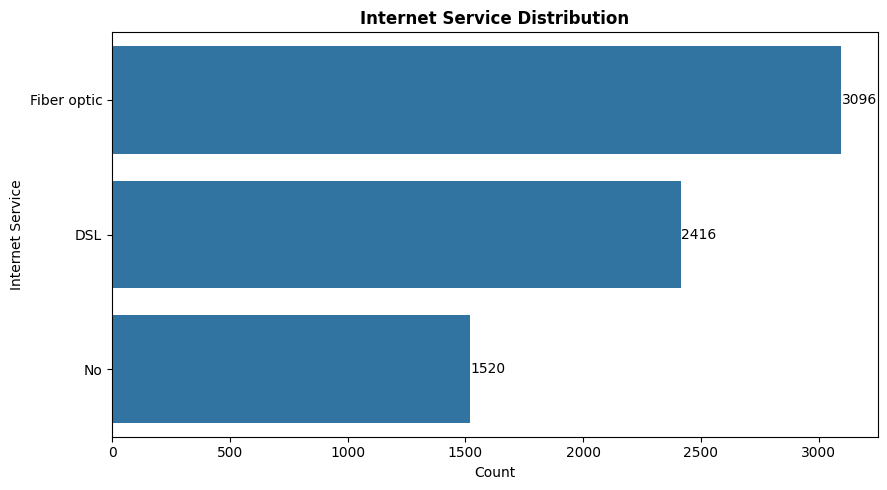

In [13]:
# Distribution of internet services plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Count of Internet Service', y='InternetService', data=internet_services)

# Add data labels
for i in ax.patches:
    ax.text(
        i.get_width() + 1,              
        i.get_y() + i.get_height() / 2,  
        int(i.get_width()),               
        ha='left', va='center'            
    )

# Add title, labels
plt.title('Internet Service Distribution', weight='bold')
plt.xlabel('Count')
plt.ylabel('Internet Service')
plt.tight_layout()
plt.show()

Check customer's contract type

In [14]:
# Customers per contract type
cust_contract = df.groupby('Contract')[['Contract']].count()
cust_contract = cust_contract.rename(columns={
    'Contract' : 'Count of Contract'
}).sort_values(by='Count of Contract', ascending=False).reset_index()
cust_contract

,Contract,Count of Contract
0,Month-to-month,3875
1,Two year,1685
2,One year,1472


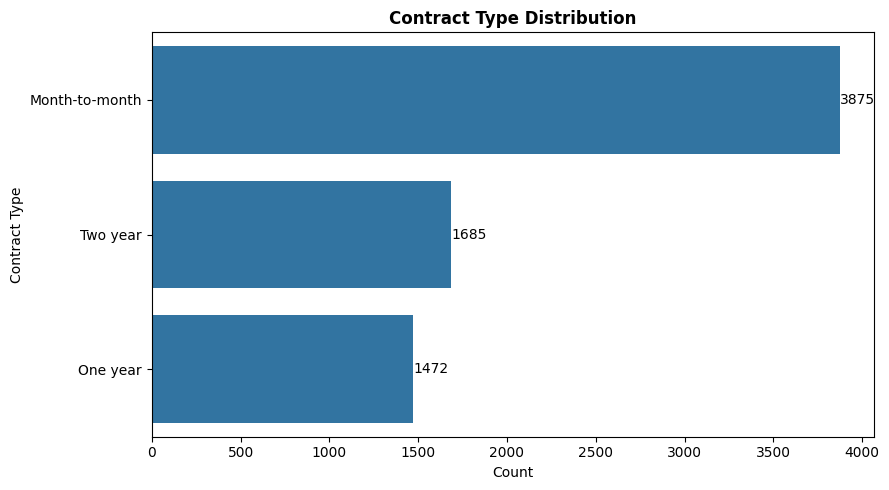

In [15]:
# Customers per contract types plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Count of Contract', y='Contract', data=cust_contract)

# Add data labels
for i in ax.patches:
    ax.text(
        i.get_width() + 1,              
        i.get_y() + i.get_height() / 2,  
        int(i.get_width()),               
        ha='left', va='center'            
    )

# Add title, labels
plt.title('Contract Type Distribution', weight='bold')
plt.xlabel('Count')
plt.ylabel('Contract Type')
plt.tight_layout()
plt.show()

Check customer's churn rate by Contract type

In [16]:
# Analyze the churn rate by Contract type
churn_by_contract = (
    df.groupby('Contract').agg(
        total_customers=('customerID', 'count'),
        churned_customers=('Churn', lambda x: (x == 'Yes').sum())
    )
    .assign(churn_rate_percent=lambda x: np.round(x['churned_customers'] * 100 / x['total_customers'], 2))
    .sort_values('churn_rate_percent', ascending=False)
    .reset_index()
)

churn_by_contract

,Contract,total_customers,churned_customers,churn_rate_percent
0,Month-to-month,3875,1655,42.71
1,One year,1472,166,11.28
2,Two year,1685,48,2.85


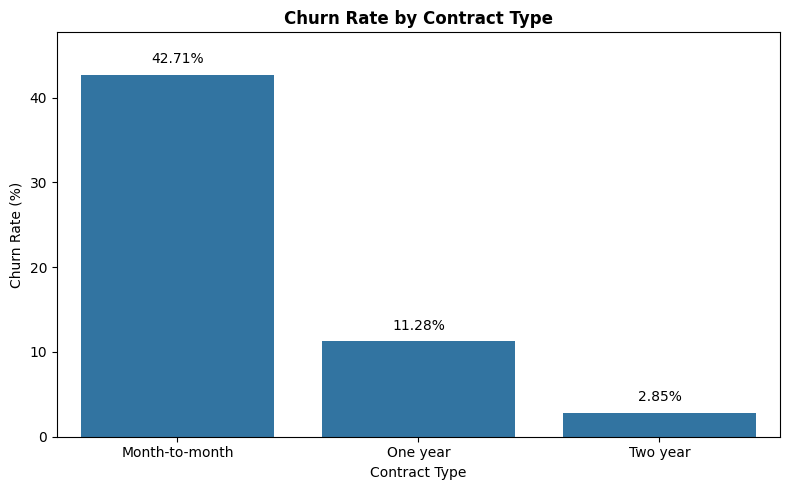

In [17]:
# Churn rate by Contract type plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Contract', y='churn_rate_percent', data=churn_by_contract)

# Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.2f}%",
        ha='center', va='bottom'
    )

plt.title('Churn Rate by Contract Type', weight='bold')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Contract Type')
plt.ylim(0, max(churn_by_contract['churn_rate_percent']) + 5) 
plt.tight_layout()
plt.show()

Check customer's average MonthlyCharges for customers who churned vs. those who didn't

In [18]:
#Investigate the average MonthlyCharges for customers who churned vs. those who didn't
avg_monthlyCharges = df.groupby(['Churn'])[['MonthlyCharges']].mean().reset_index()
avg_monthlyCharges['MonthlyCharges'] = np.round(avg_monthlyCharges['MonthlyCharges'], 2)
avg_monthlyCharges

,Churn,MonthlyCharges
0,No\r,61.31
1,Yes,74.44


Check customer's churn rate by Internet Service type

In [19]:
# Analyze the churn rate by Internet Service type
churn_by_serviceType = (
    df.groupby('InternetService').agg(
        total_customers=('customerID', 'count'),
        churned_customers=('Churn', lambda x: (x == 'Yes').sum())
    )
    .assign(churn_rate_percent=lambda x: np.round(x['churned_customers'] * 100 / x['total_customers'], 2))
    .sort_values('churn_rate_percent', ascending=False)
    .reset_index()
)
churn_by_serviceType

,InternetService,total_customers,churned_customers,churn_rate_percent
0,Fiber optic,3096,1297,41.89
1,DSL,2416,459,19.00
2,No,1520,113,7.43


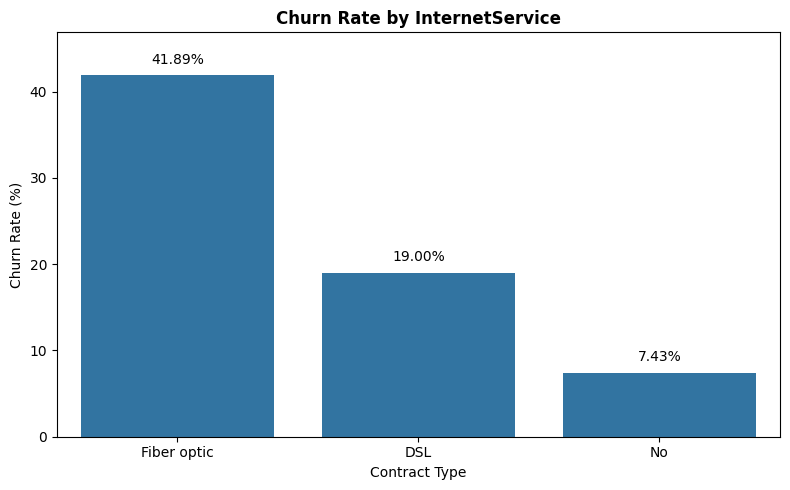

In [20]:
# Churn rate by Internet Service type Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='InternetService', y='churn_rate_percent', data=churn_by_serviceType)

# Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.2f}%",
        ha='center', va='bottom'
    )

plt.title('Churn Rate by InternetService', weight='bold')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Contract Type')
plt.ylim(0, max(churn_by_serviceType['churn_rate_percent']) + 5)
plt.tight_layout()
plt.show()

---

#### Data Pre-processing

We will conduct:
- Handle any remaining missing values (If there's any)
- Encode categorical variables
- Scale numerical features

Handle any remaining missing values (If there's any)

In [21]:
# Check if there are any extra missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Churn               0
dtype: int64

No remaining/extra missing values on the dataset.

Encoding

In [22]:
# Check columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   Contract          7032 non-null   object 
 7   PaperlessBilling  7032 non-null   object 
 8   PaymentMethod     7032 non-null   object 
 9   MonthlyCharges    7032 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7032 non-null   object 
 12  MultipleLines     7032 non-null   object 
 13  InternetService   7032 non-null   object 
 14  OnlineSecurity    7032 non-null   object 
 15  OnlineBackup      7032 non-null   object 
 16  DeviceProtection  7032 non-null   object 
 17  

In [23]:
# Check the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No\r
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No\r
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes


We can drop CustomerID column. We will encode the columns that consist of 'Yes' and 'No' values to 0 for No and 1 for Yes. The 'Contract', 'PaymentMethod', 'InternetService', using OneHot Encoder.

In [ ]:
# Pre-process function
def preprocess_telco(df, scale_numeric=True):
    df = df.copy()

    # 1. Drop customerID Column
    if 'customerID' in df.columns:
        df.drop('customerID', axis=1, inplace=True)

    # 2. Convert TotalCharges to numerical
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(0, inplace=True)

    # 3. Encode target 'Churn'
    if df['Churn'].dtype == 'object':
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # 4. Feature engineering: TotalSpent
    df['TotalSpent'] = df['MonthlyCharges'] * df['tenure']

    # 5. Encode binary 'Yes/No' columns to 1/0
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
    for col in binary_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # 6. One-hot encoding other categorical columns
    cat_cols = [
        'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
    ]

    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df

<Axes: >

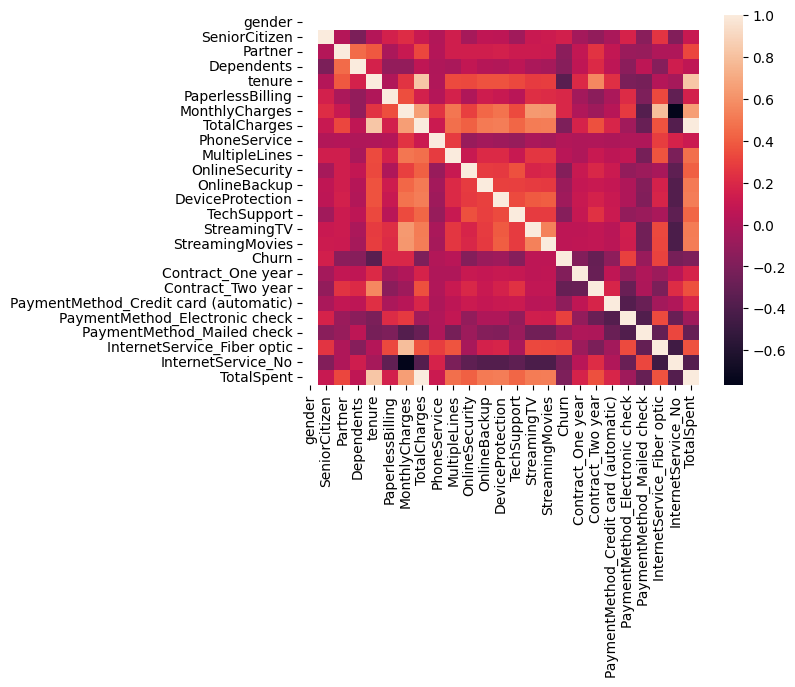

In [28]:
# Correlation analysis
sns.heatmap(df.corr())

Feature Selection and Scaling feature

In [ ]:
# Create new df copy
df_clean = preprocess_telco(df)

# Selected column
selected_features = [
    'tenure',
    'MonthlyCharges',
    'Contract_One year',
    'Contract_Two year',
    'InternetService_Fiber optic',
    'OnlineSecurity',
    'OnlineBackup',
    'TechSupport',
    'DeviceProtection',
    'PaymentMethod_Electronic check',
    'PaperlessBilling',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'StreamingTV',
    'StreamingMovies'
]

X = df_clean[selected_features]
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
#### Model Building
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

In [30]:
# Define search space
def define_search_space(trial, model_name):
    search_spaces = {
        "Logistic Regression": lambda: {
            "C": trial.suggest_float("C", 1e-4, 1e2, log=True),
            "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 500, 2000),
        },
        "Decision Tree": lambda: {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 32),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        },
        "Random Forest": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 5, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 16),
        },
        "XGBoost": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
    }

    if model_name not in search_spaces:
        raise ValueError(f"No search space defined for model: {model_name}")

    return search_spaces[model_name]()

In [31]:
# Get fixed params
def get_fixed_params(model_name):
    fixed = {'random_state': 42}
    if model_name in ["Random Forest", "XGBoost"]:
        fixed['n_jobs'] = -1
    if model_name == "XGBoost":
        fixed['use_label_encoder'] = False
        fixed['eval_metric'] = 'logloss'
    return fixed

In [32]:
# Build Pipeline
def build_pipeline(model_class, params):
    model = model_class(**params)
    return Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

In [33]:
# Objective Function
def objective(trial, model_class, model_name):
    params = define_search_space(trial, model_name)
    params.update(get_fixed_params(model_name))

    pipeline = build_pipeline(model_class, params)
    score = cross_val_score(pipeline, X_train_raw, y_train, n_jobs=-1, cv=3, scoring='roc_auc')
    return score.mean()

In [34]:
# Evaluation metric
def print_eval_report(model_name, y_test, y_pred, y_prob):
    """Prints the classification report and AUC-ROC score for a given model."""
    print(f"--- Final Evaluation Results for: {model_name} (After Hyperparameter Tuning) ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score on Test Set: {roc_auc_score(y_test, y_prob):.4f}")
    print("=" * 60 + "\n")

In [35]:
# Model tuning & Training
models_to_tune = {
    "Logistic Regression": LogisticRegression,
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "XGBoost": XGBClassifier
}

best_pipelines = {}

for model_name, model_class in models_to_tune.items():
    print(f"🔍 Tuning model: {model_name}")
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective, model_class=model_class, model_name=model_name), n_trials=25)

    best_params = study.best_params
    best_params.update(get_fixed_params(model_name))
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    final_pipeline = build_pipeline(model_class, best_params)
    final_pipeline.fit(X_train_raw, y_train)
    best_pipelines[model_name] = final_pipeline

    y_pred = final_pipeline.predict(X_test_raw)
    y_prob = final_pipeline.predict_proba(X_test_raw)[:, 1]

    print_eval_report(model_name, y_test, y_pred, y_prob)

[I 2025-06-19 11:22:38,524] A new study created in memory with name: no-name-8e20787d-0a05-4e7d-b82a-4593d1ebafb5


🔍 Tuning model: Logistic Regression


[I 2025-06-19 11:22:41,562] Trial 0 finished with value: 0.8404703805872966 and parameters: {'C': 1.1242830821603595, 'solver': 'saga', 'max_iter': 1658}. Best is trial 0 with value: 0.8404703805872966.
[I 2025-06-19 11:22:43,656] Trial 1 finished with value: 0.8343272800200636 and parameters: {'C': 0.0002193291691417605, 'solver': 'saga', 'max_iter': 1217}. Best is trial 0 with value: 0.8404703805872966.
[I 2025-06-19 11:22:45,577] Trial 2 finished with value: 0.840459222925387 and parameters: {'C': 10.147749045798413, 'solver': 'liblinear', 'max_iter': 1239}. Best is trial 0 with value: 0.8404703805872966.
[I 2025-06-19 11:22:47,784] Trial 3 finished with value: 0.8333387448051363 and parameters: {'C': 0.00012872355545814738, 'solver': 'saga', 'max_iter': 1762}. Best is trial 0 with value: 0.8404703805872966.
[I 2025-06-19 11:22:47,843] Trial 4 finished with value: 0.8404716045108694 and parameters: {'C': 2.1974025366253263, 'solver': 'saga', 'max_iter': 1712}. Best is trial 4 with v

✅ Best Parameters for Logistic Regression: {'C': 0.038112363976784705, 'solver': 'liblinear', 'max_iter': 815, 'random_state': 42}


[I 2025-06-19 11:22:50,296] A new study created in memory with name: no-name-737a8d82-53f3-4382-be5e-b03a9470b573
[I 2025-06-19 11:22:50,347] Trial 0 finished with value: 0.7972199888969113 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7972199888969113.
[I 2025-06-19 11:22:50,393] Trial 1 finished with value: 0.8148743480047586 and parameters: {'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.8148743480047586.
[I 2025-06-19 11:22:50,434] Trial 2 finished with value: 0.7975943362107375 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.8148743480047586.


--- Final Evaluation Results for: Logistic Regression (After Hyperparameter Tuning) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407

AUC-ROC Score on Test Set: 0.8361

🔍 Tuning model: Decision Tree


[I 2025-06-19 11:22:50,494] Trial 3 finished with value: 0.8029931890601731 and parameters: {'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.8148743480047586.
[I 2025-06-19 11:22:50,542] Trial 4 finished with value: 0.8173350712087762 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 32, 'criterion': 'gini'}. Best is trial 4 with value: 0.8173350712087762.
[I 2025-06-19 11:22:50,588] Trial 5 finished with value: 0.8055109123334857 and parameters: {'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8173350712087762.
[I 2025-06-19 11:22:50,635] Trial 6 finished with value: 0.8043055731292045 and parameters: {'max_depth': 18, 'min_samples_split': 29, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 4 with value: 0.8173350712087762.
[I 2025-06-19 11:22:50,681] Trial 7 finished with value: 0.8171889407012588 and pa

✅ Best Parameters for Decision Tree: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 32, 'criterion': 'entropy', 'random_state': 42}
--- Final Evaluation Results for: Decision Tree (After Hyperparameter Tuning) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1033
           1       0.52      0.72      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407

AUC-ROC Score on Test Set: 0.8268

🔍 Tuning model: Random Forest


[I 2025-06-19 11:22:52,355] Trial 0 finished with value: 0.8417570531890458 and parameters: {'n_estimators': 193, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8417570531890458.
[I 2025-06-19 11:22:53,617] Trial 1 finished with value: 0.8417031181837217 and parameters: {'n_estimators': 422, 'max_depth': 39, 'min_samples_split': 15, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8417570531890458.
[I 2025-06-19 11:22:56,570] Trial 2 finished with value: 0.8407038517246631 and parameters: {'n_estimators': 936, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8417570531890458.
[I 2025-06-19 11:22:59,305] Trial 3 finished with value: 0.8366960904044737 and parameters: {'n_estimators': 948, 'max_depth': 41, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8417570531890458.
[I 2025-06-19 11:23:00,152] Trial 4 finished with value: 0.8401684353353609 and parame

✅ Best Parameters for Random Forest: {'n_estimators': 643, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7, 'random_state': 42, 'n_jobs': -1}


[I 2025-06-19 11:23:38,011] A new study created in memory with name: no-name-f57a5a3b-7e82-4d93-9a98-37ed0fd305a9


--- Final Evaluation Results for: Random Forest (After Hyperparameter Tuning) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407

AUC-ROC Score on Test Set: 0.8415

🔍 Tuning model: XGBoost


[I 2025-06-19 11:23:38,526] Trial 0 finished with value: 0.8255980606505421 and parameters: {'n_estimators': 425, 'max_depth': 4, 'learning_rate': 0.08487880948078366, 'subsample': 0.6788444533605646, 'colsample_bytree': 0.9848149890582852}. Best is trial 0 with value: 0.8255980606505421.
[I 2025-06-19 11:23:39,303] Trial 1 finished with value: 0.7984482627083143 and parameters: {'n_estimators': 974, 'max_depth': 3, 'learning_rate': 0.2993518212821555, 'subsample': 0.5343768963446041, 'colsample_bytree': 0.5453541776763261}. Best is trial 0 with value: 0.8255980606505421.
[I 2025-06-19 11:23:39,749] Trial 2 finished with value: 0.8085239803330145 and parameters: {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.17414882202003412, 'subsample': 0.8061685182183425, 'colsample_bytree': 0.8466252346508308}. Best is trial 0 with value: 0.8255980606505421.
[I 2025-06-19 11:23:41,389] Trial 3 finished with value: 0.7883197176391729 and parameters: {'n_estimators': 934, 'max_depth': 7, '

✅ Best Parameters for XGBoost: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.011957813939441259, 'subsample': 0.8907296127525246, 'colsample_bytree': 0.7350796540961219, 'random_state': 42, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'logloss'}
--- Final Evaluation Results for: XGBoost (After Hyperparameter Tuning) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.54      0.75      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407

AUC-ROC Score on Test Set: 0.8467

